In [1]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt

#Text Color
from termcolor import colored

#Train Test Split
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

/Users/yohajji/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import wandb
from wandb.keras import WandbCallback

# Login to wandbs
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/yohajji/.netrc


True

In [5]:
# wandb config
WANDB_CONFIG = {
     'competition': 'AG News Classification Dataset', 
              '_wandb_kernel': 'neuracort'
    }

In [7]:
#File Path
TRAIN_FILE_PATH = 'train.csv'
TEST_FILE_PATH = 'test.csv'

#Load Data
data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

#Set Column Names 
data.columns = ['ClassIndex', 'Title', 'Description']
testdata.columns = ['ClassIndex', 'Title', 'Description']

#Combine Title and Description
X_train = data['Title'] + " " + data['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = data['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = testdata['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

#Max Length of sentences in Train Dataset
maxlen = X_train.map(lambda x: len(x.split())).max()
data.head()

,ClassIndex,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [8]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

# Tokenize data
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

# Pad data
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [9]:
run = wandb.init(project='ag-news', config= WANDB_CONFIG)


wandb: Currently logged in as: mohd-alhajj1913 (jjjjjjjj). Use `wandb login --relogin` to force relogin
/Users/yohajji/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dense(1024))
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 177, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 177, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 177, 128)         164352    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                        

In [11]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    WandbCallback()
]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [12]:
#Compile and Fit Model

model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          epochs=20, 
          callbacks=callbacks)

# Close W&B run
wandb.finish()

Epoch 1/20


2023-05-20 05:34:56.999064: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8549
Epoch 1: val_accuracy improved from -inf to 0.90329, saving model to weights.h5


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets
wandb: Adding directory to artifact (/Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best)... Done. 0.1s


469/469 [==============================] - 465s 984ms/step - loss: 0.3943 - accuracy: 0.8549 - val_loss: 0.2890 - val_accuracy: 0.9033
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9215
Epoch 2: val_accuracy improved from 0.90329 to 0.90750, saving model to weights.h5


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets
wandb: Adding directory to artifact (/Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best)... Done. 0.0s


469/469 [==============================] - 398s 848ms/step - loss: 0.2364 - accuracy: 0.9215 - val_loss: 0.2803 - val_accuracy: 0.9075
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9332
Epoch 3: val_accuracy improved from 0.90750 to 0.91145, saving model to weights.h5


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best/assets
wandb: Adding directory to artifact (/Users/yohajji/Desktop/Untitled Folder/wandb/run-20230520_053336-uap1z9h1/files/model-best)... Done. 0.0s


469/469 [==============================] - 422s 899ms/step - loss: 0.1977 - accuracy: 0.9332 - val_loss: 0.2783 - val_accuracy: 0.9114
Epoch 4/20
469/469 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9430
Epoch 4: val_accuracy did not improve from 0.91145
469/469 [==============================] - 404s 862ms/step - loss: 0.1661 - accuracy: 0.9430 - val_loss: 0.3047 - val_accuracy: 0.9078
Epoch 5/20
469/469 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9514
Epoch 5: val_accuracy did not improve from 0.91145
469/469 [==============================] - 414s 883ms/step - loss: 0.1395 - accuracy: 0.9514 - val_loss: 0.3090 - val_accuracy: 0.9062
Epoch 6/20
469/469 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9605
Epoch 6: val_accuracy did not improve from 0.91145
469/469 [==============================] - 417s 888ms/step - loss: 0.1128 - accuracy: 0.9605 - val_loss: 0.3443 - val_accuracy: 0.9061
Epoch 7/20
469/469 

wandb: ERROR Control-C detected -- Run data was not synced


In [31]:
model.load_weights('weights.h5')
model.save('finalModelfinall.h5')

In [14]:
def modelDemo(news_text):
                
  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [28]:
okay = input("enter")
modelDemo([okay])

enterTechnology has revolutionized the way we live, work, and connect with the world around us. It has become an integral part of our daily lives, shaping every aspect of society. From the rapid advancements in artificial intelligence to the seamless integration of smart devices, the world of technology is a captivating and ever-evolving landscape.  In today's digital age, innovation is the driving force behind technological breakthroughs. Brilliant minds are constantly pushing the boundaries of what is possible, creating futuristic marvels that once seemed like mere science fiction. Whether it's the development of self-driving cars, the exploration of virtual reality, or the limitless possibilities of the Internet of Things, technology continues to astound us with its boundless potential.  The impact of technology reaches far and wide, transforming industries and opening up new frontiers.
1/1 [==============================] - 0s 28ms/step
Technology has revolutionized the way we live

AttributeError: 'Sequential' object has no attribute 'format'

In [16]:
maxlen

177

238/238 [==============================] - 19s 79ms/step


<Figure size 432x288 with 0 Axes>

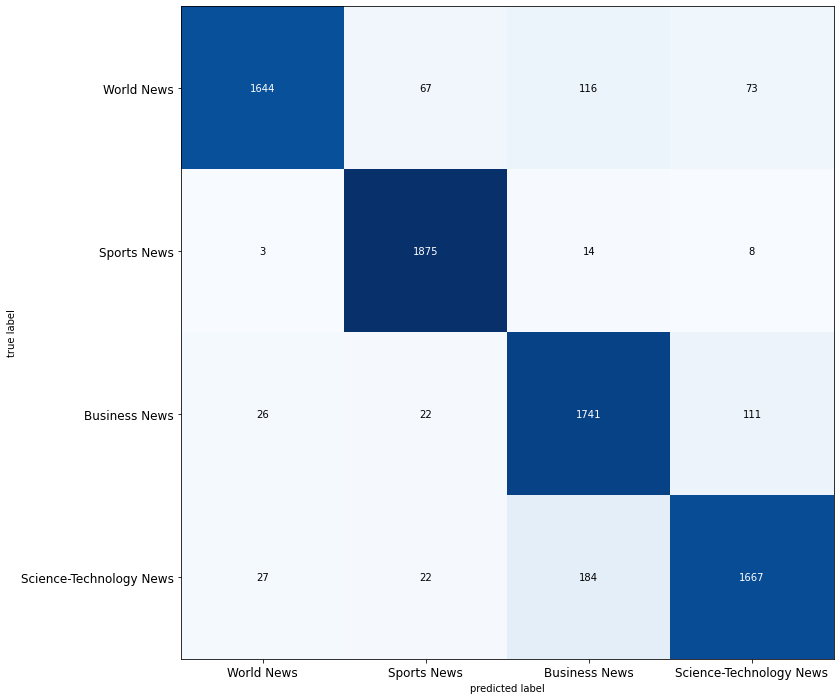

In [17]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

NameError: name 'history' is not defined